In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import emcee
import corner

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [2]:
# set random number seed to ensure reproducibility
seed = 123
rstate = np.random.RandomState(seed)

In [3]:
def gen_mock_data(m=0.875, b=2.523, s=0.523, unc=[0.2, 0.6], N=50):
    """
    Generate `N` mock data points from the line
    with slope `m`, intercept `b`, and
    intrinsic scatter `s` with measurement uncertainties
    uniformly distributed between the values in `unc` using
    a random number generator with the starting `seed`.
    
    """
        
    # generate synthetic data
    x = np.sort(3. * rstate.rand(N))  # x values
    y_int = m * x + b  # underlying line
    y = np.random.normal(y_int, s)  # with intrinsic scatter
    yerr = np.random.uniform(unc[0], unc[1], N)  # measurement errors
    yobs = np.random.normal(y, yerr)
    
    return x, yobs, yerr

(50,) (50,) (50,)


<ErrorbarContainer object of 3 artists>

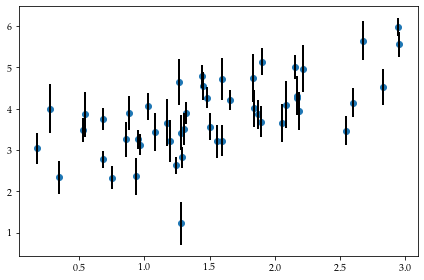

In [4]:
# generate mock data
x, y, ye = gen_mock_data()
print(x.shape, y.shape, ye.shape)
plt.scatter(x, y)
plt.errorbar(x, y, yerr = ye, capsize=0, ls='none', color='black', 
            elinewidth=2)

In [5]:
prior_means = np.array([1, 1, 1])  # m, x, b
prior_stds = np.array([1, 1, 1])  # m, x, b

In [6]:
def neglogprior(theta, mean=prior_means, std=prior_stds):
    """(Negative) log-prior as a function of parameters `theta`."""
    
    chi2 = (theta - mean)**2 / std**2
    const = np.log(2. * np.pi * std**2)
    logp = -0.5 * np.sum(chi2 + const)
    
    return -logp

In [7]:
def negloglike(theta, x=x, y=y, ye=ye):
    """(Negative) log-likelihood as a function of parameters `theta`."""
    
    m, b, s = theta  # reassign parameters
    ypred = m * x + b
    resid = ypred - y
    chi2 = resid**2 / (ye**2 + s**2)  # chi2 term
    const = np.log(2 * np.pi * (ye**2 + s**2))  
    logl = -0.5 * np.sum(chi2 + const)
    
    return -logl

In [8]:
def logpost(theta, x=x, y=y, ye=ye, mean=prior_means, std=prior_stds):
    """(Negative) log-posterior as a function of parameters `theta`."""
    
    m, b, s = theta  # reassign parameters
    logp = -neglogprior(theta, mean=mean, std=std)  # prior
    logl = -negloglike(theta, x=x, y=y, ye=ye)  # likelihood
    
    return (logl + logp)  # posterior

In [9]:
import emcee

ndim = 3  # number of parameters
nwalkers = 100  # number of "walkers" or "chains" to run

# initialize starting positions from our initial approximation
p0 = np.random.rand(nwalkers, ndim)

# initialize our sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)

# initial "burn-in" run
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

# final "production" run
state = sampler.run_mcmc(state, 500, progress=True)

# get final chains
samples = sampler.get_chain()

100%|██████████| 500/500 [00:02<00:00, 205.98it/s]


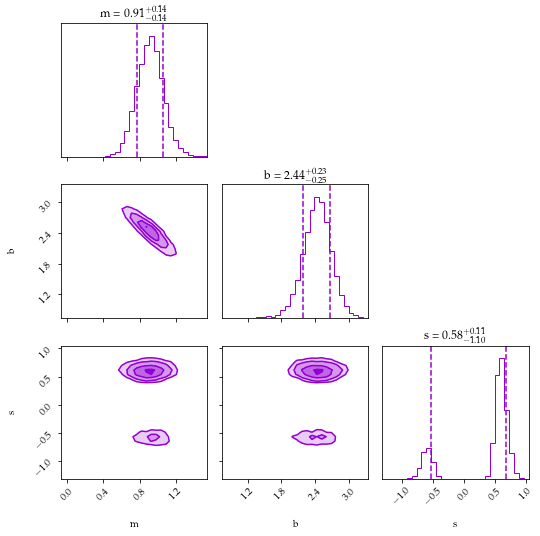

In [10]:
# plot posterior
corner.corner(samples.reshape(-1, ndim),  # collect samples into N x 3 array
              bins=30,  # bins for histogram
              show_titles=True, quantiles=[0.16, 0.84],  # show median and uncertainties
              labels=['m', 'b', 's'],
              color='darkviolet', truth_color='black',  # add some colors
              **{'plot_datapoints': False, 'fill_contours': True});  # change some default options